# 1D Fitting
---

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Set parameters

In [2]:
# Set pixel sizes [nm/px]
psx = 108
psy = psx
psz = 300

# Set optical parameters:
NA = 0.95  # numerical aperture
lambda_em = 520  # emission wavelength

# Set expected feature diameters [nm]
dx_nm = lambda_em / NA 
dy_nm = dx_nm
dz_nm = 3*dx_nm

# Convert expected feature diameters [nm --> px]
# and round up to nearest odd integer
dx = dx_nm / psx
dy = dy_nm / psy
dz = dz_nm / psz

# Round diameters up to nearest odd integer (as per `trackpy` instructions)
dx, dy, dz = np.ceil([dx, dy, dz]).astype(int) // 2 * 2 + 1

# Output
out = f"""\
Optical settings
----------------
NA.............. {NA:.2f}
Wavelength...... {lambda_em:.0f} nm
Pixelsize x..... {psx:.1f} nm/px
Pixelsize y..... {psy:.1f} nm/px
Pixelsize z..... {psz:.1f} nm/px
Diameter x...... {dx:.0f} px ({dx_nm:.1f} nm)
Diameter y...... {dy:.0f} px ({dy_nm:.1f} nm)
Diameter z...... {dz:.0f} px ({dz_nm:.1f} nm)
"""
print(out)

Optical settings
----------------
NA.............. 0.95
Wavelength...... 520 nm
Pixelsize x..... 108.0 nm/px
Pixelsize y..... 108.0 nm/px
Pixelsize z..... 300.0 nm/px
Diameter x...... 7 px (547.4 nm)
Diameter y...... 7 px (547.4 nm)
Diameter z...... 7 px (1642.1 nm)



### Create stack

In [3]:
from psf_extractor import load_stack

In [4]:
# Set directory of image stack
file_pattern = '../data/sample2_zstack_tif_sequence/'
# Load image stack
stack = load_stack(file_pattern)

  0%|          | 0/34 [00:00<?, ?it/s]

### Get features

In [5]:
import trackpy
from psf_extractor import plot_mip

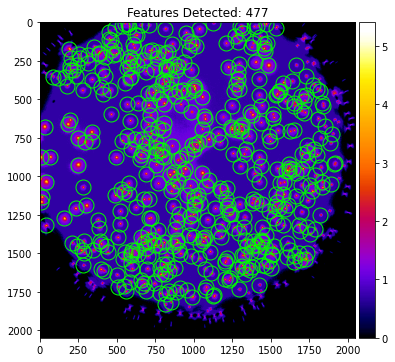

In [6]:
# Get MIP
mip = np.max(stack, axis=0)

# Locate features
df_features = trackpy.locate(mip, diameter=[dy, dx]).reset_index(drop=True)
N_features = len(df_features)

# Plot MIP
plot_mip(mip, features=df_features)

### Remove overlapping featuers

In [7]:
from psf_extractor import remove_overlapping_features, plot_overlapping_features

In [8]:
# Set dimensions of bounding box based on expected feature diameter
wx = 15 * dx_nm/psx  # px
wy = 15 * dy_nm/psy  # px

# Remove overlapping features
N_features = len(df_features)
df_features = remove_overlapping_features(df_features, wx=wx, wy=wy)

  0%|          | 0/14 [00:00<?, ?it/s]

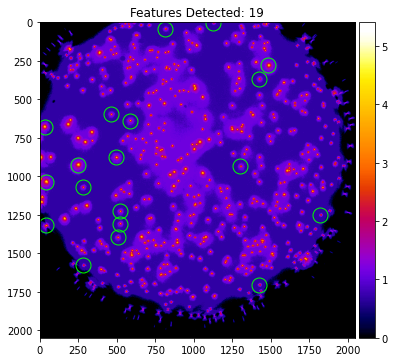

In [9]:
plot_mip(mip, features=df_features)

### Extract PSFs

In [10]:
from psf_extractor import extract_psfs, plot_psfs

In [11]:
# Set dimensions of PSF subvolume based on expected feature diameter
wx = 5 * dx_nm/psx   # px
wy = 5 * dy_nm/psy   # px
wz = 15 * dz_nm/psz  # px
shape_psf = (wz, wy, wx)

# Extract PSFs
N_features = len(df_features)
psfs, df = extract_psfs(stack, features=df_features, shape=shape_psf, return_features=True)

## Localization
---

In [12]:
from psf_extractor import (localize_psfs, plot_psf_localizations, get_Daans_special_cmap,
                           fit_gaussian_1D, fit_gaussian_2D, gaussian_1D)

In [13]:
def guess_gaussian_1D_params(y, x=None):
    """Make initial estimates for a 1D Gaussian fit"""
    # Create vector in x if not provided
    if x is None:
        x = np.arange(y.size)

    # Estimate x0
    x0 = x.mean()
    # Estimate sigma_x
    xs = x[y > y.max()/2]  # threshold at half-maximum
    # sigma = FWHM / (2*sqrt(2*ln(2))) ~ FWHM / 2.355
    sigma_x = (xs.max() - xs.min()) / 2.355
    # Estimates for amplitude and background
    A = y.max() - y.min()
    B = y.min()
    return x0, sigma_x, A, B

In [14]:
def plot_psf_stuff(psf):

    # Take MIP
    mip = np.max(psf, axis=0)
    # Dummy axis
    x = np.linspace(0, psf[:,0,0].size, 300)
    # 2D Fit
    x0, y0, sigma_x, sigma_y, A, B = fit_gaussian_2D(mip)

    # Integrate over x and y
    z_sum = psf.sum(axis=(1, 2))
    guesses_sum = guess_gaussian_1D_params(z_sum)
    fit_sum = fit_gaussian_1D(z_sum, p0=guesses_sum)
    # Slice in z through x0, y0
    z_slice = psf[:,int(y0), int(x0)]
    guesses_slice = guess_gaussian_1D_params(z_slice)
    fit_slice = fit_gaussian_1D(z_slice, p0=guesses_slice)

    # Make figure
    ncols = 3
    fig, axes = plt.subplots(ncols=ncols, figsize=(15, 2.5),
                             gridspec_kw={'width_ratios': [1, 2, 2]})
    # MIP axis (left)
    axes[0].imshow(mip, cmap=get_Daans_special_cmap())
    # Slice (center)
    axes[1].plot(z_slice, 'o', lw=1, ms=5, label='slice')
    axes[1].plot(x, gaussian_1D(x, *guesses_slice), 'k', ls=':', label='guess')
    axes[1].plot(x, gaussian_1D(x, *fit_slice), 'C2', label='fit')
    # Sum (right)
    axes[2].plot(z_sum, 'o--', lw=1, ms=5, label='sum')
    axes[2].plot(x, gaussian_1D(x, *guesses_sum), 'k', ls=':', label='guess')
    axes[2].plot(x, gaussian_1D(x, *fit_sum), 'C2', label='fit')
    [ax.grid(ls=':') for ax in axes[1:]]
    [ax.legend(loc=1) for ax in axes[1:]];

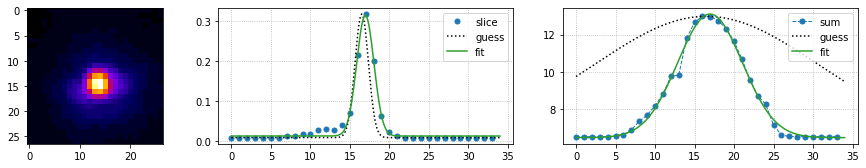

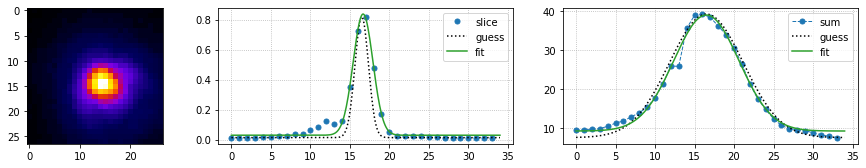

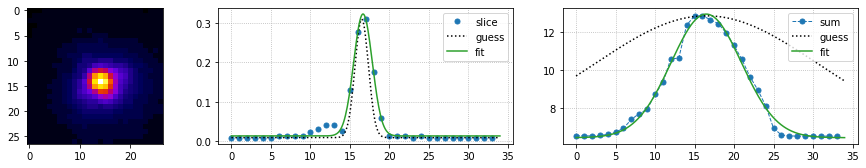

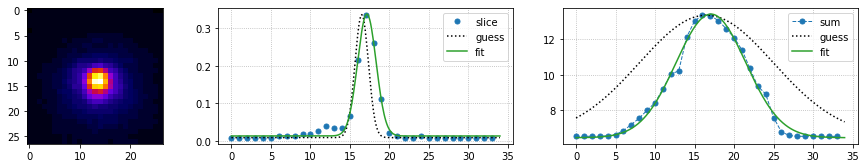

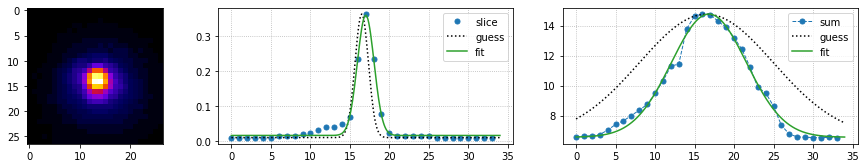

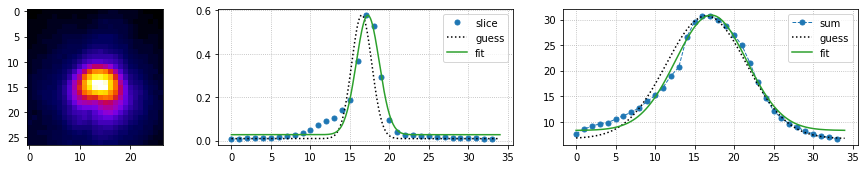

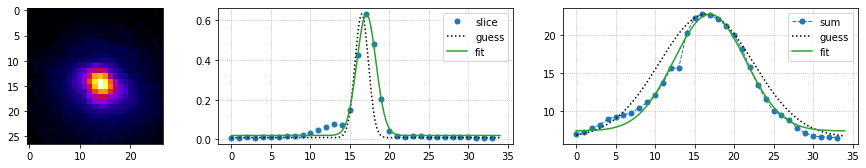

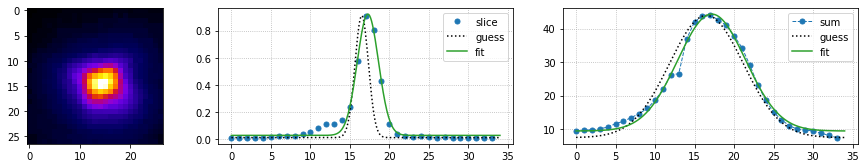

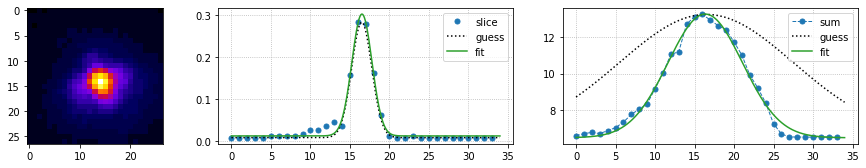

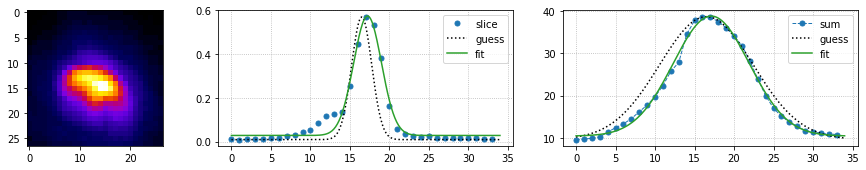

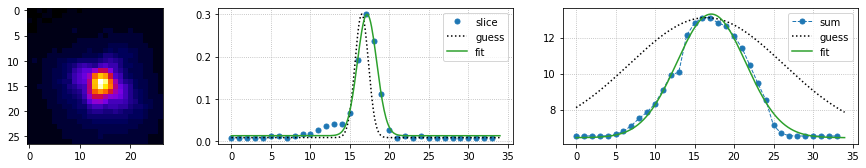

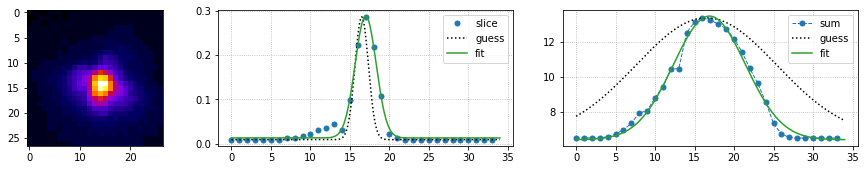

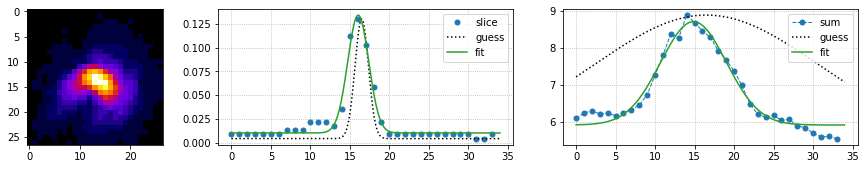

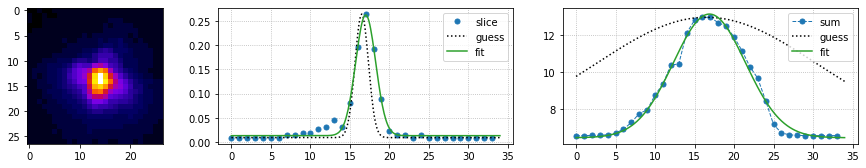

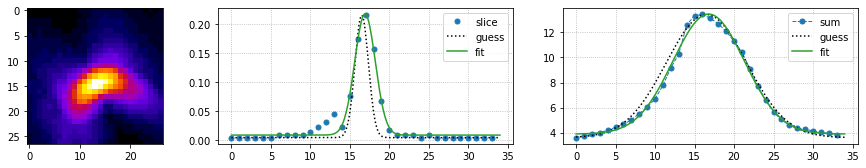

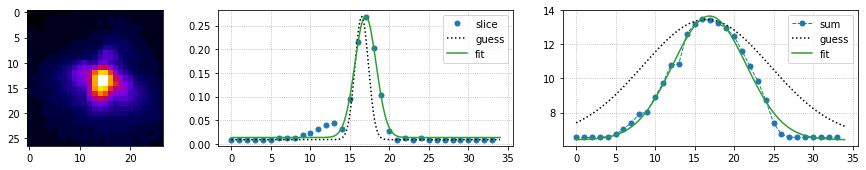

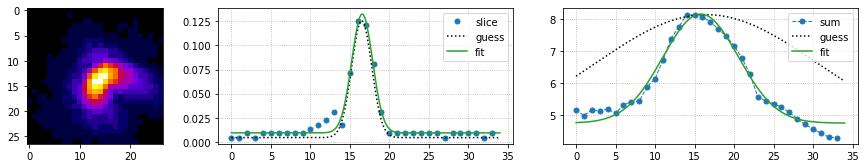

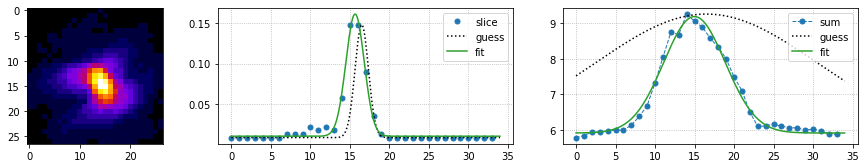

In [15]:
for psf in psfs[:]:
    plot_psf_stuff(psf)